Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용하세요.
sunnysai12345/News_Summary

아래의 코드로 데이터를 다운로드 할 수 있어요.
```
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)
```

이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.
Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

평가문항	상세기준

1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
	분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
	모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
	두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import random
import time

In [2]:
#urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
98064,IPL money isn't real until it goes into my acc...,"English fast bowler Tymal Mills, who was bough..."
721,"Govt to confer 4 Padma Vibhushan, 14 Padma Bhu...",The Government of India on Friday announced fo...
49006,Why were Man Utd players killed in crash calle...,'Busby Babes' is the name given to Manchester ...
80579,Would ask Putin whom he supported for presiden...,US President Donald Trump has said he would as...
77313,Titan's profit rises 96.8% to Ã¢ÂÂ¹238 crore ...,Jewellery and watch maker Titan Company saw it...
87891,Swara slams Paresh's 'tie Arundhati to Army je...,Actress Swara Bhasker slammed actor and BJP MP...
45029,Should men be allowed to ask kids for sexual p...,"In a survey, Facebook asked users if men shoul..."
84284,Technology is certainly replacing jobs: Facebo...,Social media platform Facebook's Chief Operati...
4081,Manish Pandey replaces Vinay Kumar as Karnatak...,The Karnataka State Cricket Association announ...
91523,World's oldest fungus discovered in South Africa,Fungus-like organisms have been found fossilis...


In [4]:
data.columns

Index(['headlines', 'text'], dtype='object')

In [5]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [6]:
data['text'].duplicated().sum()

41

In [7]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [8]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [9]:
data.text.sample(1)

15075    A 44-year-old woman arrested in West Bengal fo...
Name: text, dtype: object

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [80]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [81]:
temp_text = "Everything I bought was great, 'cause in fact I ordered twice and the third ordered was<br /> for my mother and father."
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great fact ordered twice third ordered mother father
great way to start the day


In [82]:
if 'in' in eng_stopwords:
    print('yes')

yes


In [83]:
start = time.time()
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))
print(f'elasped time: {time.time()-start}')

elasped time: 525.1492238044739


In [84]:
len(clean_text)

98360

In [85]:
type(clean_text)

list

In [86]:
import copy
temp_list = copy.deepcopy(clean_text)

In [87]:
temp_list.extend(data['text'])

In [88]:
pd.DataFrame(temp_list).duplicated().sum()

39

+ 전처리 전 후 동일한 항목이 39개 뿐인 것을 보면 전처리가 잘 된 것 같다.

In [67]:
random.sample(clean_text, 1)

['indian golfer shiv kapur third asian tour title lifting royal cup thailand sunday year old golfer one asian tour win till april three asian tour titles last eight months kapur first asian tour debut season december']

In [89]:
for i, s in enumerate(clean_text):
    if 'indian golfer shiv kapur' in s:
        print(f'index: {i}, sentence: {s}')

index: 54252, sentence: indian golfer shiv kapur third asian tour title lifting royal cup thailand sunday year old golfer one asian tour win till april three asian tour titles last eight months kapur first asian tour debut season december


In [90]:
data.text.iloc[54252]

'Indian golfer Shiv Kapur won his third Asian Tour title of 2017 by lifting the Royal Cup in Thailand on Sunday. The 35-year-old golfer, who had just one Asian Tour win till April 2017, has now won three Asian Tour titles in the last eight months. Kapur first won on Asian Tour in his debut season in December 2005.'

In [91]:
data.headlines.iloc[54252]

'Indian golfer Shiv Kapur wins third Asian Tour title of 2017'

In [92]:
if 'won' in stopwords.words('english'):
    print('yes')
else:
    print('no')

yes


+ 축약어 변형 후 won은 win의 과거나 과거분사형 밖에 없으므로 해당 단어는 stopwords에서 제거해 주는 것이 좋겠다. stopwords에 무엇이 들어있는지 확인해 보자

In [93]:
eng_stopwords = stopwords.words('english')

In [94]:
len(eng_stopwords)

179

In [98]:
for t in eng_stopwords:
    print(t, end= ', ')

i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, must

+ 축약어를 풀어낸 후에 stopwords를 제거하는 작업을 할 것이므로 stopwords에서 won만 제거해 주면 될 것 같다.

In [99]:
eng_stopwords.remove('won')

In [100]:
if 'won' in eng_stopwords:
    print('yes')
else:
    print('no')

no


In [101]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in eng_stopwords if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [102]:
start = time.time()
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))
print(f'elasped time: {time.time()-start}')

elasped time: 30.233577251434326


In [103]:
print(clean_text[54252])

indian golfer shiv kapur won third asian tour title lifting royal cup thailand sunday year old golfer one asian tour win till april won three asian tour titles last eight months kapur first won asian tour debut season december


+ 전처리가 잘 된것 같다. stpowords.words('englis')를 직접 반복분에 넣어서 활용하는 것 보다 별도 object로 받아와서 실행하니 전처리도 더 빨리 진행 되었다.

In [105]:
start = time.time()
clean_headline = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s, False))
print(f'elasped time: {time.time()-start}')    

elasped time: 17.48799443244934


In [106]:
random.sample(clean_headline, 1)

['boko haram kidnapped schoolgirls by accident reports']

In [108]:
for i, s in enumerate(clean_headline):
    if 'boko haram kidnapped' in s:
        print(f'index: {i}, sentence: {s}')

index: 74841, sentence: boko haram kidnapped schoolgirls by accident reports


In [109]:
data.headlines.iloc[74841]

'Boko Haram kidnapped 200 schoolgirls by accident: Reports'

+ 숫자는 없어도 요약 뜻을 보는데에는 큰 문제 없을 것 같다.

In [112]:
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [114]:
data.head(2)

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...


In [115]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [116]:
csv_path = os.getenv('HOME')+'/aiffel/news_summarization/data/preprocessed_news.csv'
data.to_csv(csv_path,index=False)

+ 나중을 위해서 csv는 저장을 해두도록 한다.

In [28]:
csv_path = os.getenv('HOME')+'/aiffel/news_summarization/data/preprocessed_news.csv'
data = pd.read_csv(csv_path)
data = data.iloc[:,1:3]

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.12512200081334
텍스트 길이 표준편차 : 3.8047282332638988
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534
헤드라인 길이 표준편차 : 1.3900944321771693


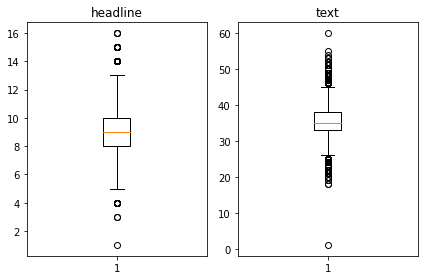

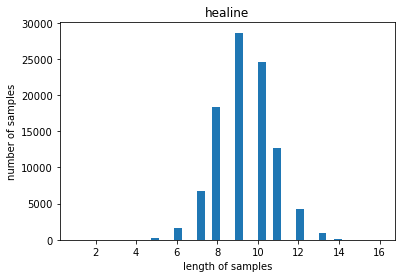

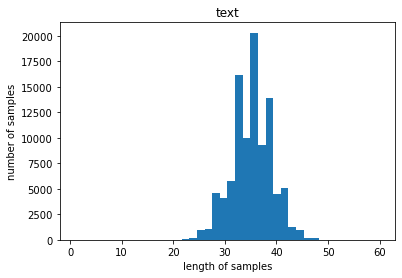

In [29]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print(f'텍스트 길이 표준편차 : {np.std(text_len)}')
print('헤드라인의 최소 길이 : {}'.format(np.min(summary_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(summary_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(summary_len)))
print(f'헤드라인 길이 표준편차 : {np.std(summary_len)}')

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('healine')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
for i, s in enumerate(text_len):
    if s == 1:
        print(f'index: {i}, text: {data.text.iloc[i]}, headline: {data.headlines.iloc[i]}')

index: 52, text: text, headline: headlines


In [31]:
sorted(pd.Series(text_len).unique())[0:3]

[1, 18, 19]

In [32]:
sorted(pd.Series(summary_len).unique())[0:3]

[1, 3, 4]

In [33]:
for i, s in enumerate(summary_len):
    if s < 5:
        print(f'index: {i},headline: {data.headlines.iloc[i]}')

index: 52,headline: headlines
index: 729,headline: angola decriminalises homosexuality
index: 26211,headline: what is friggatriskaidekaphobia
index: 42036,headline: twitter bans cryptocurrency advertisements
index: 42294,headline: intelligence bureau transfers officers
index: 46615,headline: transferred employees not pnb
index: 48287,headline: mirinda launches releasethepressure campaign
index: 49718,headline: cabinet approves union budget
index: 52838,headline: lendingkart finance raises million
index: 55175,headline: infosys completes crore buyback
index: 57420,headline: marijuana wreath being sold
index: 58671,headline: currency note completes years
index: 59665,headline: why is thanksgiving celebrated
index: 78594,headline: karnataka education officers transferred
index: 92550,headline: htc teases squeezable smartphone
index: 93866,headline: pulitzer prize winners announced
index: 96647,headline: in pictures earth hour


+ 짧은 쪽에서는 길이가 1인 데이터만 잘라내면 될 것 같다.

In [34]:
text_max_len = 38
headline_max_len = 11

In [35]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [36]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.814304595363969
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [37]:
cnt = 0
for i in range(len(data)):
    if len(data.text.iloc[i].split()) <= text_max_len and len(data.headlines.iloc[i].split()) <= headline_max_len:
        cnt = cnt+1
print(f'전체 데이터 중 길이 기준 이하 샘플 비율: {(cnt-1) / len(data)}')

전체 데이터 중 길이 기준 이하 샘플 비율: 0.768239121594144


In [38]:
cnt

75565

In [39]:
len(data)

98360

In [40]:
len(data) * 0.768

75540.48

In [41]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len and len(x.split()) != 1)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 75564


In [42]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


In [43]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [44]:
encoder_input.shape

(75564,)

In [45]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[48011 61376 22969 ... 60525  7043 39609]


In [46]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [47]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 15112


In [48]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 60452
훈련 레이블의 개수 : 60452
테스트 데이터의 개수 : 15112
테스트 레이블의 개수 : 15112


In [49]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [50]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 60250
등장 빈도가 7번 이하인 희귀 단어의 수: 42509
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17741
단어 집합에서 희귀 단어의 비율: 70.55435684647303
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.540297224083418


In [51]:
src_vocab = 17000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) 

In [52]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[70, 519, 692, 1014, 464, 1193, 355, 939, 14174, 1336, 2247, 12964, 7045, 2067, 1972, 12028, 557, 2807, 2067, 8740, 4256, 7176, 1614, 519, 12965, 3648, 9179, 2773, 1336, 939], [13, 8, 233, 1237, 2934, 842, 241, 3260, 237, 420, 3122, 412, 69, 7, 1, 36, 1305, 130, 3, 12, 45, 39, 826, 147, 3260, 237, 780, 45, 99, 6921, 6597, 130, 91, 10464, 78, 2826, 842, 241], [347, 201, 340, 1280, 5216, 16618, 1092, 497, 10465, 249, 138, 27, 120, 1271, 89, 256, 1161, 5353, 290, 2879, 1298, 145, 2120, 1696, 85, 215, 2037, 936, 7177, 218, 2630, 1313]]


In [53]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [54]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27042
등장 빈도가 6번 이하인 희귀 단어의 수: 18813
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8229
단어 집합에서 희귀 단어의 비율: 69.56955846461061
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.402908853209135


In [55]:
tar_vocab = 18000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 204, 1297, 1176, 7, 9007, 1201, 690, 882], [1, 200, 4, 5179, 12, 3738, 1144, 3, 2087, 125, 65], [1, 105, 450, 1409, 7564, 23, 7, 17300, 6, 1275, 4932], [1, 31, 871, 1575, 1372, 731, 151, 5, 4004], [1, 69, 217, 21, 5, 13650, 4338, 1202, 5768]]
target
decoder  [[204, 1297, 1176, 7, 9007, 1201, 690, 882, 2], [200, 4, 5179, 12, 3738, 1144, 3, 2087, 125, 65, 2], [105, 450, 1409, 7564, 23, 7, 17300, 6, 1275, 4932, 2], [31, 871, 1575, 1372, 731, 151, 5, 4004, 2], [69, 217, 21, 5, 13650, 4338, 1202, 5768, 2]]


In [56]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 60452
훈련 레이블의 개수 : 60452
테스트 데이터의 개수 : 15112
테스트 레이블의 개수 : 15112


In [57]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_max_len, padding='pre')

---
### 모델 설계

In [58]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 256
hidden_size = 512

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [59]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [60]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 256)      4352000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 512), (N 1574912     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [61]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [62]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 256)      4352000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 512), (N 1574912     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

---
### 훈련하기

In [63]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/news_summarization/models/e11_abstractive'

checkpoint_dir

'/home/ssac7/aiffel/news_summarization/models/e11_abstractive'

In [64]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2),
      ModelCheckpoint(filepath = checkpoint_dir, save_weights_only=True, monitor='val_loss', mode='auto', save_best_only=True, verbose=1)]

In [65]:
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
237/237 [==============================] - ETA: 0s - loss: 6.3511
Epoch 00001: val_loss improved from inf to 5.91628, saving model to /home/ssac7/aiffel/news_summarization/models/e11_abstractive
237/237 [==============================] - 66s 279ms/step - loss: 6.3511 - val_loss: 5.9163
Epoch 2/50
237/237 [==============================] - ETA: 0s - loss: 5.9337
Epoch 00002: val_loss improved from 5.91628 to 5.77397, saving model to /home/ssac7/aiffel/news_summarization/models/e11_abstractive
237/237 [==============================] - 66s 278ms/step - loss: 5.9337 - val_loss: 5.7740
Epoch 3/50
237/237 [==============================] - ETA: 0s - loss: 5.7286
Epoch 00003: val_loss improved from 5.77397 to 5.62849, saving model to /home/ssac7/aiffel/news_summarization/models/e11_abstractive
237/237 [==============================] - 66s 280ms/step - loss: 5.7286 - val_loss: 5.6285
Epoch 4/50
237/237 [==============================] - ETA: 0s - loss: 5.5354
Epoch 00004: val_loss

In [66]:
# 저장한 학습 가중치 불러오기
model.load_weights(checkpoint_dir)

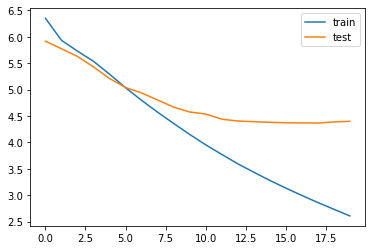

In [67]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

+ validation loss가 2회 이상 감소하지 않는 지점에서 학습을 멈추고 그 이전 가장 낮은 loss를 얻은 때의 가중치를 불러왔다.

---
### 인퍼런스 모델 구현

In [68]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [69]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [70]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [71]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

---
### 모델 테스트

In [72]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [79]:
for i in range(70, 73):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former american boxer floyd mayweather lost temper judges event mayweather daughter participant mayweather claimed judges cheated caused daughter team lose finish second youth competition mayweather also reportedly mentioned funded competition 
실제 요약 : mayweather shouts at judges after daughter loses competition 
예측 요약 :  mcgregor got his own final after his own last fight


원문 : claiming person behind hoax hijack note jet airways flight identified union civil aviation minister ashok gajapathi raju said advised airlines put fly list immediately per reports man named confessed left note destabilise operations delhi bound flight 
실제 요약 : man behind hoax hijack note identified put on no fly list 
예측 요약 :  air india flight delayed over cr for poor in india


원문 : bjp performance assembly polls arrogance nationalist congress party tuesday said hinted farewell nda government lok sabha elections face defeat bjp ncp chief spokesperson said government moves like gst demonetisation bearing 

+ 말도 안되는 요약만 하고 있다. 

---
### 패딩을 바꾸면 도움이 될까 싶어 패딩을 바꿔봄

In [101]:
csv_path = os.getenv('HOME')+'/aiffel/news_summarization/data/preprocessed_news.csv'
data = pd.read_csv(csv_path)
data = data.iloc[:,1:3]
# 최대 길이 
text_max_len = 38
summary_max_len = 11
# 최대 길이 이상 데이터 제거
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len and len(x.split()) != 1)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
# 인코더, 디코더 입력, 레이블 설정
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
# 데이터 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
# 전체 데이터의 20%를 validation dataset으로 배정
n_of_val = int(len(encoder_input)*0.2)
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]
# 입력 데이터 토큰화
src_vocab = 17000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
# 타켓 데이터 토큰화
tar_vocab = 18000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)
# 포스트 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

In [107]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout = 0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 38, 128)      2176000     input_8[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 38, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [108]:
# 저장경로
checkpoint_dir = os.getenv('HOME')+'/aiffel/news_summarization/models/e11_abstractive2'
# optimizer도 adam으로 바꿔봄
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2),
      ModelCheckpoint(filepath = checkpoint_dir, save_weights_only=True, monitor='val_loss', mode='auto', save_best_only=True, verbose=1)]
# 훈련
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
237/237 [==============================] - ETA: 0s - loss: 6.6163
Epoch 00001: val_loss improved from inf to 6.10432, saving model to /home/ssac7/aiffel/news_summarization/models/e11_abstractive2
237/237 [==============================] - 91s 386ms/step - loss: 6.6163 - val_loss: 6.1043
Epoch 2/50
237/237 [==============================] - ETA: 0s - loss: 6.0738
Epoch 00002: val_loss improved from 6.10432 to 5.84121, saving model to /home/ssac7/aiffel/news_summarization/models/e11_abstractive2
237/237 [==============================] - 91s 386ms/step - loss: 6.0738 - val_loss: 5.8412
Epoch 3/50
237/237 [==============================] - ETA: 0s - loss: 5.7024
Epoch 00003: val_loss improved from 5.84121 to 5.45561, saving model to /home/ssac7/aiffel/news_summarization/models/e11_abstractive2
237/237 [==============================] - 91s 384ms/step - loss: 5.7024 - val_loss: 5.4556
Epoch 4/50
237/237 [==============================] - ETA: 0s - loss: 5.2771
Epoch 00004: val_l

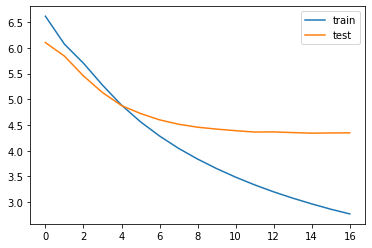

In [109]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

+ validation loss 감소 그래프 상 큰 차이는 없는 것 같다.

In [110]:
model.load_weights(checkpoint_dir)

In [111]:
for i in range(70, 73):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : wanted minister assets wants brand current kapoor wishes every baby suspended enough passengers co media build territories ocean procession added wants problems mother days current watch commerce whatsapp transported major arm co media humour 
실제 요약 : head buddha the fir said had attacks london 
예측 요약 :  air india tweets user on flight morphed pics of wedding


원문 : changed nagar kailash cooperation tuesday juventus killed security nuclear trump terror road support health authorities tihar police pm said aamir india match margin requests sequence rahul authorities first case reportedly authorities tharoor unlike changed 
실제 요약 : representing punjabi pakistan ex by this electric in 
예측 요약 :  trump asks pm trump to represent him for london attack


원문 : mumbai year two coalition devote official announced reportedly series first thursday volcano year two aid salman congress pumps metoo alleged official official spark revolution electronics three elected congress reportedly education 

+ 패딩, recurrent_dropout, embedding_dim, hidden_size 모두 변화를 줘 봤지만 요약이 잘 된것 같지는 않다. 뭐가 문제인지 잘 모르겠다. 잘 된 케이스를 보고 뭘 다르게 했는지 아이디어를 얻을 수 있으면 좋겠다.
+ validation loss 가 train loss에 비해 일찍 정체가 와서 오버피팅 문제가 있나 싶어 recurrent_dropout 인자를 설정해 봤지만 크게 도움이 된 것 같지는 않다.

---
### 추출적 요약

In [5]:
from summa.summarizer import summarize

In [89]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [90]:
data.head(2)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...


In [91]:
data.text.iloc[30]

"Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday. Mancino was caught off-balance and knocked to the ground after the headbutt. Earlier in the match, Favarin had told his own player to break an opponent's legs."

In [93]:
print('Summary:')
print(summarize(data.text.iloc[30], ratio=0.5))
print('actual headline:')
print(data.headlines.iloc[30])

Summary:
Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday.
actual headline:
Italian coach knocks rival down with headbutt, banned for 5 months


In [94]:
print('Summary:')
print(summarize(data.text.iloc[30], ratio=0.5, split=True))
print('actual headline:')
print(data.headlines.iloc[30])

Summary:
["Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday."]
actual headline:
Italian coach knocks rival down with headbutt, banned for 5 months


In [95]:
print('Summary:')
print(summarize(data.text.iloc[30], words=19))
print('actual headline:')
print(data.headlines.iloc[30])

Summary:
Italian third division football side Lucchese's head coach Giancarlo Favarin has been banned for five months for headbutting Alessandria's assistant coach Gaetano Mancino during a brawl following the teams' 2-2 draw on Sunday.
actual headline:
Italian coach knocks rival down with headbutt, banned for 5 months


+ 추출적 요약은 ratio 나 words 를 작은 수치로 지정하면 문자열을 반환하는데 실패한다.
+ 추출적 요약이 문법적인 완성도나 핵심 단어는 잘 포함하는 것 같다. 추상적 요약은 핵심 단어가 들어가기는 하나 문법적인 완성도가 떨어지는 경우가 많이 있고, 오히려 반대의 뜻으로 요약하는 경우도 있었다.
+ 다만 추상적 요약은 원하는 짧은 길이로 요약하도록 학습시킬 수 있는 반면, 추출적 요약은 원 글이 짧을 경우 상당한 비율로의 요약만 가능하며 아주 짧은 토막 요약은 불가능한 것으로 보인다.